In [1]:
from FedMSLesSeg.data_loader import load_and_prepare_data, split_dataset, split_dataset_among_clients
from FedMSLesSeg.gradient_descent import evaluate_model, train_logistic_regression
from FedMSLesSeg.fed_gradient_descent import train_federated_model
import matplotlib.pyplot as plt
# from FedMSLesSeg.logger import get_logger, configure_logging
import time

In [3]:
def main():
    # Load and preprocess the dataset
    print("Loading and preparing dataset...")
    dataset = load_and_prepare_data()
    print("Dataset loaded successfully.")

    # Split dataset for global evaluation
    global_train, global_test = split_dataset_among_clients([dataset])[0]
    fed_avg_losses, fed_avg_errors, fed_times = [], [], []
    central_avg_losses, central_avg_errors, central_global_times = [], [], []
    
    for i in range(1, 101, 5):
        clients_datasets = split_dataset_among_clients(split_dataset(dataset, split_ratios=i))

        # Determine input dimension from a sample
        X_sample, _ = clients_datasets[0][0][0]
        input_dim = X_sample.shape[0]

        # === Federated Training ===
        print("\nStarting Federated Training...")
        start_time = time.time()
        w_fed, b_fed = train_federated_model(clients_datasets, input_dim)
        fed_training_time = time.time() - start_time
        print(f"Federated training completed in {fed_training_time:.2f} seconds.")
        
        # Evaluate federated model
        print("Evaluating Federated Model...")
        avg_loss, avg_error = evaluate_model(w_fed, b_fed, global_test)
        fed_avg_losses.append((i, avg_loss))
        fed_avg_errors.append((i,avg_error))
        fed_times.append((i,fed_training_time))
        print(f"Final Test Loss: {avg_loss:.4f} - Final Test Error: {avg_error:.4f}")

        # === Global Training (Centralized) ===
        print("\nStarting Centralized Training...")
        start_time = time.time()
        w_global, b_global = train_logistic_regression(global_train)
        global_training_time = time.time() - start_time
        print(f"Centralized training completed in {global_training_time:.2f} seconds.")

        # Evaluate global model
        print("Evaluating Centralized Model...")
        avg_loss, avg_error = evaluate_model(w_global, b_global, global_test)
        print(f"Final Test Loss: {avg_loss:.4f} - Final Test Error: {avg_error:.4f}")
        central_avg_losses.append((1, avg_loss))
        central_avg_errors.append((1, avg_error))
        central_global_times.append((1, global_training_time))
        

    print("Centralized training times:", central_global_times)
    print("Federated training timess:", fed_times)
    print("Centralized average losses:", central_avg_losses)
    print("Centralized average errors:", central_avg_errors)
    print("Federated average losses:", fed_avg_losses)
    print("Federated average errors:", fed_avg_errors)

    return fed_avg_losses, fed_avg_errors, fed_times, central_avg_losses, central_avg_errors, central_global_times

In [4]:
fed_avg_losses, fed_avg_errors, fed_times, central_avg_losses, central_avg_errors, central_global_times = main()

Loading and preparing dataset...
Dataset loaded successfully.
Split ratios: [1.0]

Starting Federated Training...
Federated training completed in 7.33 seconds.
Evaluating Federated Model...
Final Test Loss: 2.2037 - Final Test Error: 0.1404

Starting Centralized Training...
Centralized training completed in 7.51 seconds.
Evaluating Centralized Model...
Final Test Loss: 0.9897 - Final Test Error: 0.0614
Split ratios: [0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]

Starting Federated Training...
Federated training completed in 8.67 seconds.
Evaluating Federated Model...
Final Test Loss: 2.8312 - Final Test Error: 0.1754

Starting Centralized Training...
Centralized training completed in 7.48 seconds.
Evaluating Centralized Model...
Final Test Loss: 3.1896 - Final Test Error: 0.2018
Split ratios: [0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.09090909090909091, 0.0909090

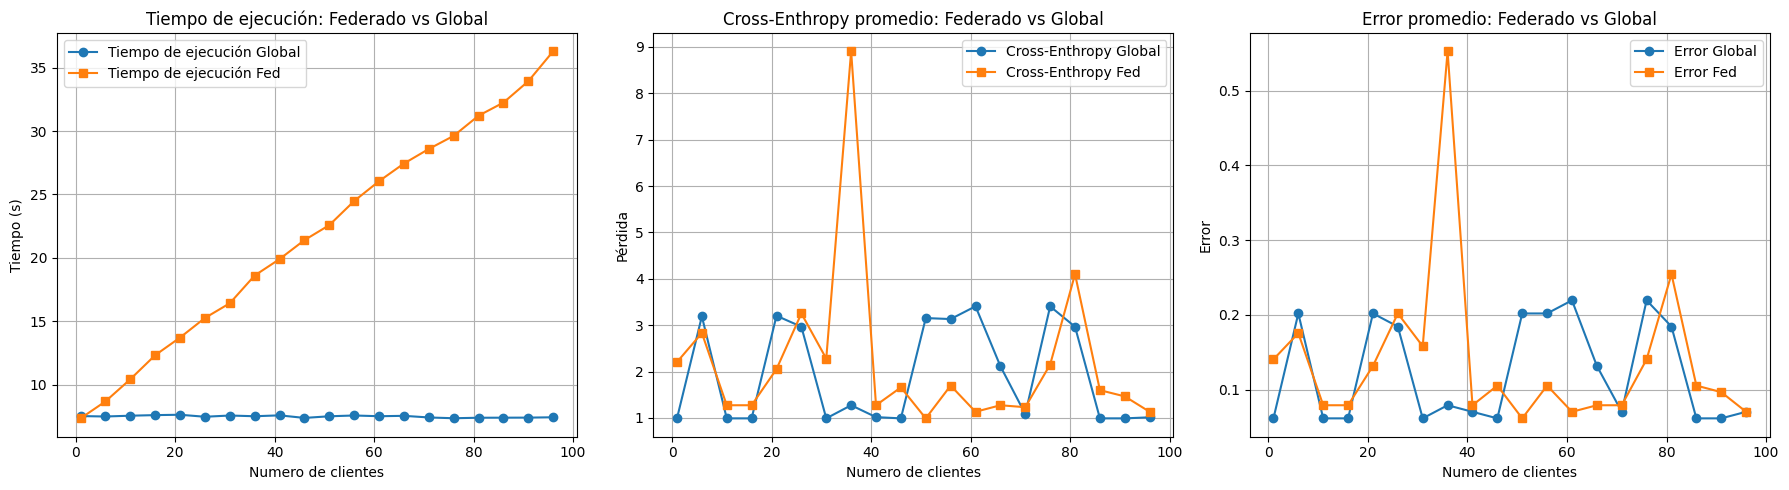

In [5]:
# Suponiendo que tienes tres pares de conjuntos de datos
central_global_timesX, central_global_timesY = zip(*central_global_times)
fed_timesX, fed_timesY = zip(*fed_times)

central_avg_lossesX, central_avg_lossesY = zip(*central_avg_losses)
fed_avg_lossesX, fed_avg_lossesY = zip(*fed_avg_losses)

central_avg_errorsX, central_avg_errorsY = zip(*central_avg_errors)
fed_avg_errorsX, fed_avg_errorsY = zip(*fed_avg_errors)

# Crear figura con 3 subplots en una fila
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # (filas, columnas)

# Subgráfico 1
axs[0].plot(fed_timesX, central_global_timesY, label='Tiempo de ejecución Global', marker='o')
axs[0].plot(fed_timesX, fed_timesY, label='Tiempo de ejecución Fed', marker='s')
axs[0].set_title("Tiempo de ejecución: Federado vs Global")
axs[0].set_xlabel("Numero de clientes")
axs[0].set_ylabel("Tiempo (s)")
axs[0].grid(True)
axs[0].legend()

# Subgráfico 2
axs[1].plot(fed_avg_lossesX, central_avg_lossesY, label='Cross-Enthropy Global', marker='o')
axs[1].plot(fed_avg_lossesX, fed_avg_lossesY, label='Cross-Enthropy Fed', marker='s')
axs[1].set_title('Cross-Enthropy promedio: Federado vs Global')
axs[1].set_xlabel('Numero de clientes')
axs[1].set_ylabel('Pérdida')
axs[1].grid(True)
axs[1].legend()

# Subgráfico 3
axs[2].plot(fed_avg_errorsX, central_avg_errorsY, label='Error Global', marker='o')
axs[2].plot(fed_avg_errorsX, fed_avg_errorsY, label='Error Fed', marker='s')
axs[2].set_title('Error promedio: Federado vs Global')
axs[2].set_xlabel('Numero de clientes')
axs[2].set_ylabel('Error')
axs[2].grid(True)
axs[2].legend()

# Ajustar el espacio
plt.tight_layout()
plt.show()
